# 学习器集成--一个训练集多个分类器

1、硬投票：分类最多的作为结果返回  
2、软投票：分类器权重×分类器结果概率再取均值，最后概率值最大的类别为结果返回

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500,noise=.3,random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear',random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto',random_state=42)

In [4]:
voting_clf_hard = VotingClassifier(
estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
voting='hard')


In [30]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf_hard):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [31]:
svm_clf = SVC(gamma='auto',random_state=42,probability=True)

voting_clf_soft = VotingClassifier(
estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
voting='soft')

for clf in (log_clf, rnd_clf, svm_clf, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


# 训练集集成--不同训练集相同分类器

1、有放回采样--Bagging  
2、无放回采样--pasting

In [2]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,max_samples=100,
                            bootstrap=True,n_jobs=-1,random_state=42)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.904

In [6]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train,y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test,y_pred_tree)

0.856

In [ ]:
# Bagging采样方法是对m个实例的训练集，有放回抽样m次。；因此对每个样本，m次都未选中的概率是(1-1/m)**m。当m越大，此概率趋近1/e=0.37，即m次中至少1次选中的概率是0.632。
# m中包含实例a1~am,令xi=0(ai未选中）或1（ai选中至少1次），sum(xi)就是m中被选中过的实例数。sum(xi)的期望就是选中过的实例数的平均值，即m个(1*0.632+0*0.368)的和，为0.632m个实例。

In [2]:
import numpy as np
(1-1/1e10)**1e10

0.36787941071455793

In [3]:
# out of bag 评估
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),n_estimators=500,bootstrap=True,n_jobs=-1,oob_score=True,random_state=40)
bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.9013333333333333

In [4]:
# 返回决策函数的每个实例类别概率
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [5]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

BaggingClassifier 的随机贴片/随机子空间  
随机贴片：对训练实例和特征的采样  
随机子空间：对特征采样（bootstrap_features=True并且/或者max_features小于 1.0）  
采样特征导致更多的预测多样性，用高偏差换低方差。

# 随机森林  
可以方便了解特征重要度，特别是特征选择时候

In [4]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [13]:
#以下bagging类似上面的randomforestclassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
DTC = DecisionTreeClassifier(splitter='random',max_leaf_nodes=16)
bag_clf = BaggingClassifier(DTC,n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

# 极端随机树

在每个节点分裂时只考虑随机特征值上的特征  
也是用高偏差换低方差，训练更快  

# 特征重要度

In [10]:
# feature_importance_属性
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(iris['data'],iris['target'])
for name, score in sorted(zip(iris['feature_names'],rnd_clf.feature_importances_)):
    print(name,score)


petal length (cm) 0.45344639318712826
petal width (cm) 0.43281266247668565
sepal length (cm) 0.09014903436281974
sepal width (cm) 0.023591909973366125


In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [5]:
rnd_clf = RandomForestClassifier(n_estimators=10,random_state=42)
rnd_clf.fit(mnist.data, mnist.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [9]:
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,interpolation="nearest")
    plt.axis("off")

[Text(1, 0, 'Not important'), Text(1, 0, 'Very important')]

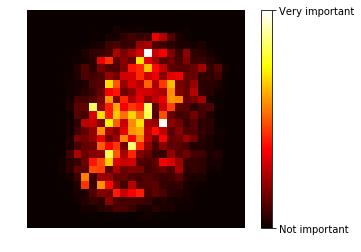

In [11]:
from matplotlib import pyplot as plt
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

# 学习器集成--提升  
## 适应性提升：AdaBoost  
新分类器的训练集是上一个分类器的y_pred与y_train对照过的加权后的训练集，原理是对之前分类结果不对的训练实例多加关注  


In [16]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
  DecisionTreeClassifier(max_depth=1), n_estimators=200,
  learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

In [ ]:
#模拟实现
m = len(X_train)
sample_weights=np.ones(m)
for i in range(5):
  svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
  svm_clf.fit(X_train,y_train,sample_weight=sample_weights)
  y_pred = svm_clf.predict(X_train)
  sample_weights[y_pred!=y_train] *= 1.5

## 梯度提升:Gradient Boosting  
超参数learning_rate 确立了每个树的贡献。  
如果你把它设置为一个很小的树，例如 0.1，在集成中就需要更多的树去拟合训练集，但预测通常会更好。这个正则化技术叫做 shrinkage。

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
##梯度提升的弱学习器设定，限定了baseEstimator只能为决策树
gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1,random_state=42)
gbrt.fit(X,y)

D:\Program Files\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [4]:
# 模拟实现
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2,random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2,random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

## 梯度提升的早期停止法  
自带的staged_predict()方法

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val)]

best_n_estimators = np.argmin(errors)
min_error = np.min(errors)

In [23]:
len(errors)

120

In [24]:
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=best_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
best_n_estimators

55

Text(0.5, 1.0, 'Best model (55 trees)')

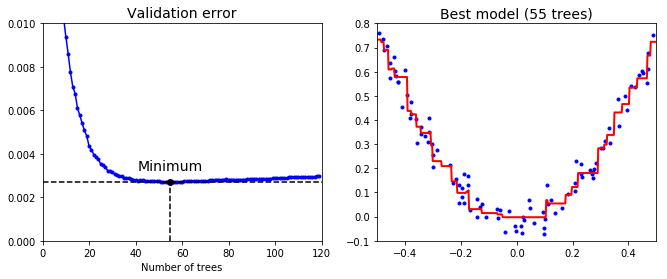

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)


def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)


模拟方法  
可以通过设置warm_start=True来实现 ，  
这使得当fit()方法被调用时 sklearn 保留现有树，并允许增量训练。

In [28]:
#结果与上相同
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break 
            
print(gbrt.n_estimators, "Minimum validation MSE:", min_val_error)

61 Minimum validation MSE: 0.002712853325235463


In [29]:
min_error

0.002712853325235463

随机梯度提升方法  
GradientBoostingRegressor也支持指定用于训练每棵树的训练实例比例的超参数subsample。例如如果subsample=0.25，那么每个树都会在 25% 随机选择的训练实例上训练。你现在也能猜出来，这也是个高偏差换低方差的作用。它同样也加速了训练。这个技术叫做随机梯度提升。

# 梯度提升：XGBoost